<a href="https://colab.research.google.com/github/HARSHINI20/mobilenet_img_classifier/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: SETUP ENVIRONMENT
!pip install -q googletrans==4.0.0-rc1
!pip install -q tensorflow


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langsmith 0.3.11 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.
openai 1.61.1 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.


In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/archive.zip'  # <- Change path if needed
extract_path = '/content/garbage_classification/garbage_classification/garbage_classification'
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
print("✅ Dataset extracted to:", extract_path)

✅ Dataset extracted to: /content/garbage_classification/garbage_classification/garbage_classification


In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from googletrans import Translator
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# STEP 2: EXTRACT DATASET ZIP FROM DRIVE
#zip_path = '/content/drive/MyDrive/archive.zip'  # your ZIP path
#extract_path = '/content/garbage_classification/garbage_classification'
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
 #   zip_ref.extractall(extract_path)


In [ ]:
# STEP 3: DEFINE IMAGE PARAMETERS
img_height, img_width = 224, 224
batch_size = 32


In [ ]:
# STEP 4: PREPARE DATA
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

In [ ]:
train_gen = datagen.flow_from_directory(
    extract_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 12415 images belonging to 12 classes.


In [ ]:
val_gen = datagen.flow_from_directory(
    extract_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 3100 images belonging to 12 classes.


In [ ]:
class_indices = train_gen.class_indices
idx_to_label = {v: k for k, v in class_indices.items()}

In [ ]:

# Save class indices
class_indices = train_gen.class_indices
index_to_label = {v: k for k, v in class_indices.items()}
print("📂 Class Labels:", index_to_label)

📂 Class Labels: {0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [ ]:
# STEP 5: BUILD MODEL (Freeze Base)
base_model = MobileNetV2(include_top=False, input_shape=(img_height, img_width, 3), weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# STEP 6: TRAIN 10 EPOCHS (Frozen Base)
model.fit(train_gen, validation_data=val_gen, epochs=10)

# STEP 7: UNFREEZE TOP 20 LAYERS, TRAIN 5 MORE
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=5)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


388/388 ━━━━━━━━━━━━━━━━━━━━ 58s 124ms/step - accuracy: 0.4607 - loss: 1.7583 - val_accuracy: 0.7739 - val_loss: 0.8162
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.8577 - loss: 0.6139 - val_accuracy: 0.8429 - val_loss: 0.5497
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.9036 - loss: 0.3994 - val_accuracy: 0.8619 - val_loss: 0.4525
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - accuracy: 0.9145 - loss: 0.3290 - val_accuracy: 0.8732 - val_loss: 0.4023
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.9301 - loss: 0.2739 - val_accuracy: 0.8858 - val_loss: 0.3649
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.9371 - loss: 0.2432 - val_accuracy: 0.8897 - val_loss: 0.3491
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - accuracy: 0.9410 - loss: 0.2212 - val_accuracy: 0.8974 - val_loss: 0.3211
Epoch 8/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.9476 - loss: 0.1989 - val_accura

In [ ]:
# STEP 8: SAVE MODEL
model_path = '/content/drive/MyDrive/garbage_copy.h5'
model.save(model_path)
print("✅ Model saved at:", model_path)

✅ Model saved at: /content/drive/MyDrive/garbage_copy.h5


In [ ]:

# STEP 9: DEFINE PREDICTION FUNCTION
def predict_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((img_width, img_height))
    img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))

    pred = model.predict(img_array)[0]
    class_idx = np.argmax(pred)
    confidence = float(pred[class_idx])
    label = idx_to_label[class_idx]

    return label, confidence


In [ ]:
 #STEP 10: TRANSLATE TWEET TO ENGLISH
def translate_tweet(tweet_text):
    translator = Translator()
    translated = translator.translate(tweet_text, dest='en')
    return translated.text.lower()

In [ ]:
# STEP 11: MATCH TWEET WITH IMAGE
def match_tweet_with_image(tweet_text, image_path):
    print("🔍 Original Tweet:", tweet_text)

    translated_text = translate_tweet(tweet_text)
    print("🌍 Translated Tweet:", translated_text)

    label, confidence = predict_image(image_path)
    print(f"🖼️ Predicted Image Label: {label} (Confidence: {confidence*100:.2f}%)")

    if label in translated_text:
        print("✅ MATCH FOUND: Image aligns with tweet.")
    else:
        print("❌ MISMATCH: Tweet and image do not align.")

In [ ]:
# === STEP 12 ===
from google.colab import files
uploaded = files.upload()

img_path = list(uploaded.keys())[0]

import matplotlib.pyplot as plt
from PIL import Image






Saving trash.jpeg to trash.jpeg


In [ ]:
def match_tweet_with_image(tweet_text, image_path):
    print("\n🔍 Original Tweet:", tweet_text)

    translated_text = translate_tweet(tweet_text)
    print("🌍 Translated Tweet:", translated_text)

    label, confidence = predict_image(image_path)

    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"🖼️ Predicted: {label} ({confidence*100:.2f}%)", fontsize=14, color='green')
    plt.show()

    if label.lower() in translated_text:
        print("✅ MATCH FOUND: Image aligns with tweet.")
    else:
        print("❌ MISMATCH: Tweet and image do not align.")

📝 Enter tweet text here:  मेरी प्लास्टिक की बोतल को रीसायकल करें

🔍 Original Tweet:  मेरी प्लास्टिक की बोतल को रीसायकल करें
🌍 Translated Tweet: recycle my plastic bottle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


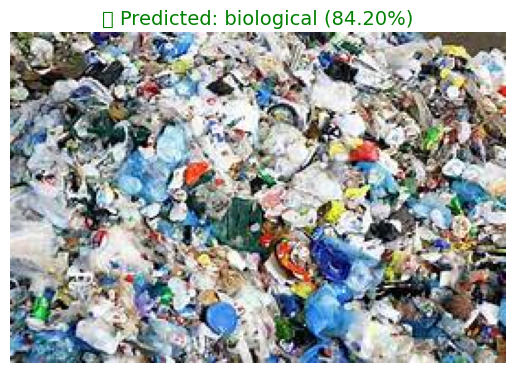

❌ MISMATCH: Tweet and image do not align.


In [ ]:
# === User Input
tweet = input("📝 Enter tweet text here: ")
match_tweet_with_image(tweet, img_path)